In [2]:
!pip install awswrangler

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 933.4 kB/s eta 0:00:0000:01
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 3.1 MB/s eta 0:00:0000:01
  Using cached jsonpath_ng-1.5.3-py3-none-any.whl (29 kB)
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Using cached gremlinpython-3.6.1-py2.py3-none-any.whl (73 kB)
  Using cached redshift_connector-2.0.909-py3-none-any.whl (112 kB)
  Using cached aenum-3.1.11-py3-none-any.whl (131 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached aiohttp-3.8.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached scramp-1.4.4-py3-none-any.whl (13 kB)
  Using cached python_

In [54]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from tqdm import tqdm 

role = get_execution_role()
s3 = boto3.resource('s3')

In [55]:
def plot_time_distr(tot, title, n_days=2, delta_hours=6):
    omega_hours = 24 // delta_hours
    m0 = tot[tot.time>=0]
    f, ax = plt.subplots()
    b = np.linspace(0,n_days*24*60,100)
    _ = m0.groupby('a_patientid').time.min().hist(bins=b, ax=ax)
    _ = ax.set_title(title)
    _ = ax.set_xticks([i*60*delta_hours for i in range(n_days*omega_hours)])
    _ = ax.set_xticklabels([i*delta_hours for i in range(n_days*omega_hours)])
    _ = ax.set_xlabel('Time [hours]')
    return f, ax

In [56]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [57]:
variables = wr.s3.read_parquet(path="s3://icusics-db/d_variables/d_variables.parquet")
# variables_h4 = variables[variables.hospital_coded==4]
# diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h4.parquet")
# labresults_numeric = wr.s3.read_parquet(path="s3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet")

# Check for predictors variable_id

Predictors:
 - Albumine
 - Potassium
 - SpO2
 - Haematocrit
 - Ph
 - Blood Urine Nitrate / Urea * 0.357

Outcome:
 - CRRT

In [58]:
time_window = 24 * 60

In [59]:
# Albumine

alb_idx = [
    1024000512,2024000340,3024001802,
    4024002341,5024001802,6024002862
]

albumine = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(alb_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    if i == 1:
        ith.loc[:,'value'] = ith.loc[:,'value'] / 10
    ith = ith[(ith.value >= 0.5) & (ith.value <= 15)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    albumine.append(ith)
    
albumine = pd.concat(albumine)
albumine.columns = ['albumine_min','albumine_max']
albumine.to_csv('./tmp/tmp_table.csv')
albumine = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
albumine.head()

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


,albumine_min,albumine_max
a_patientid,,
1000091,2.43,2.43
1000109,2.68,2.68
1002069,1.86,2.16
1002635,3.32,3.32
1002875,2.15,2.15


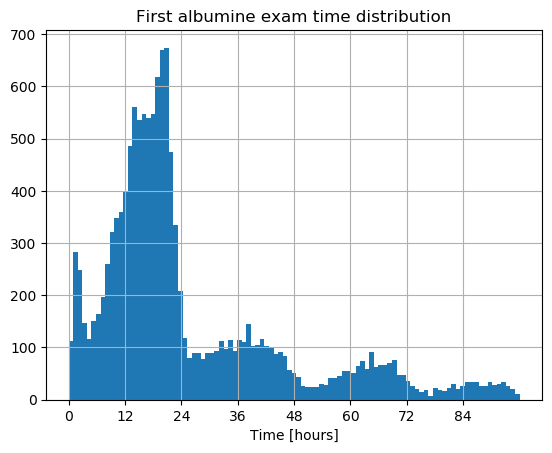

In [60]:
tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First albumine exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [61]:
# Potassium

potassium_idx = [
    1020000500,2020000500,3020000500,
    4020000500,5020000500,6020000500
]

potassium = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(potassium_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith[(ith.value >= 2) & (ith.value <= 10)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    potassium.append(ith)
    
potassium = pd.concat(potassium)
potassium.columns = ['potassium_min','potassium_max']
potassium.to_csv('./tmp/tmp_table.csv')
potassium = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
potassium.head()

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]


,potassium_min,potassium_max
a_patientid,,
1000091,2.99,2.99
1000109,2.50,3.20
1000211,4.47,4.47
1001170,3.40,4.10
1001535,3.60,3.80


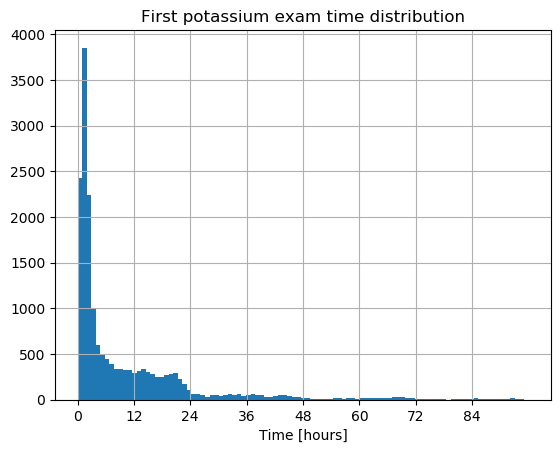

In [62]:
tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First potassium exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [63]:
# Haematocrit

haema_idx = [
    1020000100,2020000100,3020000100,
    4020000100,5020000100,6020000100
]

haematocrit = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(haema_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith[(ith.value >= 5) & (ith.value <= 80)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    haematocrit.append(ith)
    
haematocrit = pd.concat(haematocrit)
haematocrit.columns = ['haematocrit_min','haematocrit_max']
haematocrit.to_csv('./tmp/tmp_table.csv')
haematocrit = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
haematocrit.head()

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


,haematocrit_min,haematocrit_max
a_patientid,,
1000091,28.5,28.5
1000109,29.0,33.0
1000211,36.8,36.8
1000999,34.6,35.5
1001170,19.0,27.0


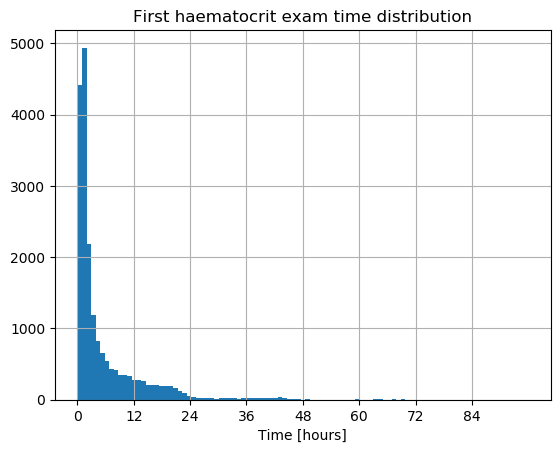

In [64]:
tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First haematocrit exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [65]:
# Ph

ph_idx = [
    1020000300,2020000300,3020000300,
    4024001491,5020000300,6020000300
]
ph = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(ph_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith[(ith.value >= 6.5) & (ith.value <= 7.8)]

    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    ph.append(ith)
    
ph = pd.concat(ph)
ph.columns = ['ph_min','ph_max']
ph.to_csv('./tmp/tmp_table.csv')
ph = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
ph.head()


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


,ph_min,ph_max
a_patientid,,
1000109,7.46,7.49
1000999,7.40,7.50
1001000,7.29,7.42
1001170,7.28,7.41
1001535,7.34,7.46


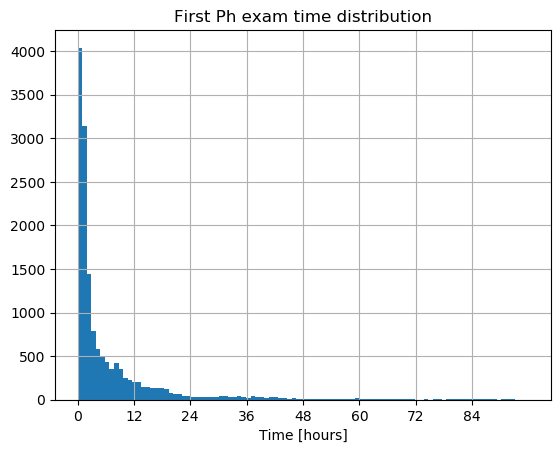

In [66]:
tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First Ph exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [67]:
# Blood Urine Nitrogen
# urea * 0.357

bun_idx = [
    1020004100,2020004100,3020004100,
    4020004100,5024001806,5020004100,
    6020004100
]

bun = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(bun_idx)]
    ith.loc[:, 'value'] *= 0.357
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    bun.append(ith)
    
bun = pd.concat(bun)
bun.columns = ['bun_min','bun_max']
bun.to_csv('./tmp/tmp_table.csv')
bun = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
bun.head()

  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
 17%|█▋        | 1/6 [00:00<00:02,  1.76it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
 33%|███▎      | 2/6 [00:00<00:02,  1.99it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexi

,bun_min,bun_max
a_patientid,,
1000091,15.708,15.708
1000109,21.777,21.777
1000211,14.280,14.280
1002069,29.631,43.197
1002635,12.495,12.495


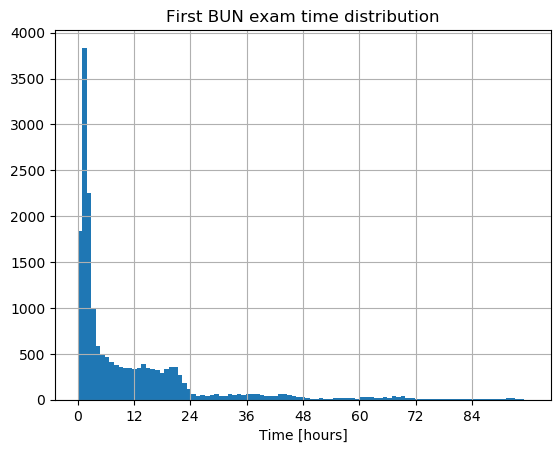

In [68]:
tot = pd.concat(tot)
f, ax = plot_time_distr(tot, 'First BUN exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [69]:
# SpO2

idx = [
    1000004000,2000004000,3000004000,
    4000004000,5000004000,6000004000, # SpO2
]

spo2 = []
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0].values):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    
    ith = ith_monitored[ith_monitored.a_variableid.isin(idx)]
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    ith = ith[(ith.value >= 0) & (ith.value <= 100)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    spo2.append(ith)

spo2 = pd.concat(spo2)
spo2.columns = ['spo2_min','spo2_max']

spo2.to_csv('./tmp/tmp_table.csv')
spo2 = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
spo2.head()

100%|██████████| 600/600 [04:59<00:00,  2.00it/s]


,spo2_min,spo2_max
a_patientid,,
1000091,76.0,100.0
1000109,90.0,100.0
1000211,93.0,100.0
1000999,93.0,100.0
1001000,73.0,100.0


In [70]:
features = albumine.reset_index()
features = features.merge(potassium.reset_index(), how='outer', on='a_patientid')
features = features.merge(spo2.reset_index(), how='outer', on='a_patientid')
features = features.merge(haematocrit.reset_index(), how='outer', on='a_patientid')
features = features.merge(ph.reset_index(), how='outer', on='a_patientid')
features = features.merge(bun.reset_index(), how='outer', on='a_patientid')
features

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,spo2_min,spo2_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,bun_max
0,1000091,2.43,2.43,2.99,2.99,76.0,100.0,28.5,28.5,NaN,NaN,15.708,15.708
1,1000109,2.68,2.68,2.50,3.20,90.0,100.0,29.0,33.0,7.46,7.49,21.777,21.777
2,1002069,1.86,2.16,3.53,3.94,38.0,100.0,32.5,39.6,NaN,NaN,29.631,43.197
3,1002635,3.32,3.32,4.77,4.77,92.0,100.0,41.7,41.7,NaN,NaN,12.495,12.495
4,1002875,2.15,2.15,4.33,4.33,86.0,100.0,24.7,30.6,NaN,NaN,14.994,14.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039,2483256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.42,NaN,NaN
21040,2483940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.13,7.23,NaN,NaN
21041,2690275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.44,NaN,NaN
21042,5843585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.276,24.276


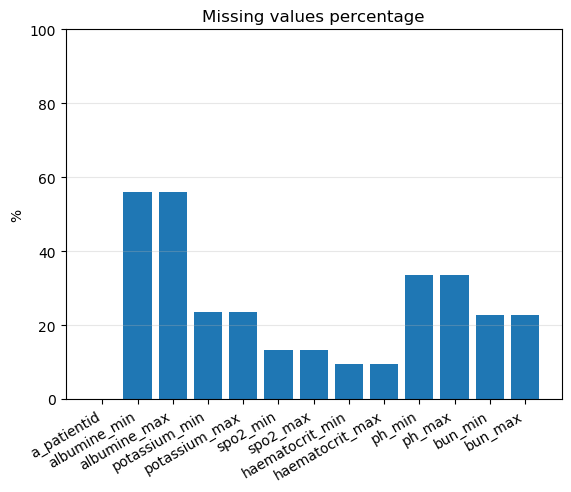

In [71]:
f, ax = plt.subplots()

missing = (features.isna().sum() / features.shape[0]) * 100
_ = ax.bar(x=range(missing.shape[0]), height=missing)
_ = ax.set_xticks(range(missing.shape[0]))
_ = ax.set_xticklabels(missing.index.tolist(), rotation=30, ha='right')
_ = ax.grid(alpha=0.3, axis='y')
_ = ax.set_ylim((0,100))
_ = ax.set_ylabel('%')
_ = ax.set_title('Missing values percentage')
plt.show()

## CRRT

In [72]:
flux_idx = [
    1000001380,1000005666, # Flux
    2000001380,2000005666,
    3000001380,3000005666,
    4000001380,4000005666,
    5000001380,5000005666,
    6000001380,6000005666
]

flux = []
flux_tot = []
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0].values):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    
    flux_ith = ith_monitored[ith_monitored.a_variableid.isin(flux_idx)]
    flux_tot.append(flux_ith)
    flux_ith_grp = flux_ith.groupby(['a_patientid','a_variableid']).time.min()
    flux.append(flux_ith_grp)

flux = pd.concat(flux)
flux_tot = pd.concat(flux_tot)
flux.head()

100%|██████████| 600/600 [04:50<00:00,  2.06it/s]


a_patientid  a_variableid
1001000      1000001380      1723
1002069      1000001380       345
1004363      1000001380      1004
1004645      1000001380       910
1008444      1000001380       448
Name: time, dtype: Int64

In [73]:
asd = flux.reset_index()
asd.time = asd.time.astype(float)
asd.a_variableid = asd.a_variableid.apply(lambda x: str(x)[2:])
asd = asd[asd.a_variableid.str.endswith('1380')]
#asd = asd[asd.time>=time_window]
outcome = asd.loc[:, ['a_patientid','time']]
outcome = outcome.rename(columns={'time':'crrt_time'})
outcome

,a_patientid,crrt_time
0,1001000,1723.0
1,1002069,345.0
2,1004363,1004.0
3,1004645,910.0
4,1008444,448.0
...,...,...
1654,6947160,1458.0
1655,6953205,1583.0
1656,6969036,15700.0
1657,6988953,23.0


## Comorbidities

 - Diabetes
 - Chronic Kidney Disease
 - Hyper tension
 - Heart failure

In [74]:
icusics_db_patients = wr.s3.read_parquet(path="s3://icusics-db/patients/patients.parquet")

icd_codes=[]
for h in icusics_db_patients.hospital_coded.unique():
    diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h%s.parquet"%h)
    icd_codes.append(diagnoses)

icd_codes= pd.concat(icd_codes)

## Diabetes

In [75]:
name = "diabetes"

idx = np.where(icd_codes.referencecodename.str.contains("Diabetis mellitus|diabetes mellitus|Diabetis", case=False))[0]
comorbidity = icd_codes.iloc[idx].drop_duplicates(subset=["referencecode"])

comorbidity= list(comorbidity.referencecode.unique())
comorbidity = icd_codes[icd_codes["referencecode"].isin(comorbidity)]

dm= comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
dm[name] = 1

dm

,a_patientid,diabetes
0,1001773,1
1,1002304,1
2,1002515,1
3,1002635,1
4,1003351,1
...,...,...
2293,6960538,1
2294,6980223,1
2295,6980759,1
2296,6982644,1


## Heart Failure

In [76]:
name ='heart failure'

comorbidity=icd_codes[icd_codes["referencecode"].str.startswith(("I50", "428", "408", "I11"))] # codes in the excel file "Predictors_IDS"
hf= comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
hf[name] = 1
hf

,a_patientid,heart failure
0,1000999,1
1,1002304,1
2,1024481,1
3,1025942,1
4,1026475,1
...,...,...
620,6785831,1
621,6787603,1
622,6843201,1
623,6879026,1


## Hypertension

In [77]:
name ='hypertension'

comorbidity=icd_codes[icd_codes["referencecode"].str.startswith(("I10", "401", "402", "I15","I13", "I11"))] # codes in the excel file "Predictors_IDS"
hyp= comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
hyp[name] = 1
hyp

,a_patientid,hypertension
0,1001773,1
1,1002304,1
2,1003351,1
3,1003886,1
4,1004336,1
...,...,...
4341,6980759,1
4342,6986777,1
4343,6996899,1
4344,6998846,1


## Chronic Kidney Disease

In [78]:
name ='chronic kidney disease'

comorbidity=icd_codes[icd_codes["referencecode"].str.startswith(("I13", "N18", "585", "D63"))] # codes in the excel file "Predictors_IDS"
ids_to_exclude = ["585.6","585.6/2"]
comorbidity=comorbidity[~comorbidity.referencecode.isin(ids_to_exclude)]

ckd= comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
ckd[name] = 1
ckd

,a_patientid,chronic kidney disease
0,1001773,1
1,1002304,1
2,1003351,1
3,1006422,1
4,1014041,1
...,...,...
898,6858536,1
899,6859543,1
900,6882314,1
901,6924180,1


## RRT

In [79]:
name ='RRT'

comorbidity=icd_codes[icd_codes["referencecode"].isin(["N18.6","Z99.2"])] # codes in the excel file "Predictors_IDS"
rrt= comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
rrt[name] = 1
rrt

,a_patientid,RRT
0,1592559,1
1,1601194,1
2,1771355,1
3,1773413,1
4,1807359,1
5,3070128,1
6,3246549,1
7,3421760,1
8,3802161,1
9,4122886,1


In [80]:
comorbidity = dm.merge(hf, how="outer")
comorbidity = comorbidity.merge(hyp, how="outer")
comorbidity = comorbidity.merge(ckd, how="outer")
comorbidity = comorbidity.merge(rrt, how="outer")

#comorbidity = comorbidity.fillna(0)
comorbidity

,a_patientid,diabetes,heart failure,hypertension,chronic kidney disease,RRT
0,1001773,1.0,NaN,1.0,1.0,NaN
1,1002304,1.0,1.0,1.0,1.0,NaN
2,1002515,1.0,NaN,NaN,NaN,NaN
3,1002635,1.0,NaN,NaN,NaN,NaN
4,1003351,1.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...
5705,6834415,NaN,NaN,NaN,1.0,NaN
5706,6858536,NaN,NaN,NaN,1.0,NaN
5707,6882314,NaN,NaN,NaN,1.0,NaN
5708,6924180,NaN,NaN,NaN,1.0,NaN


In [81]:
dataset = features.merge(comorbidity, how='left', on='a_patientid')
dataset = dataset.merge(outcome, how='left', on='a_patientid')
dataset

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,spo2_min,spo2_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,bun_max,diabetes,heart failure,hypertension,chronic kidney disease,RRT,crrt_time
0,1000091,2.43,2.43,2.99,2.99,76.0,100.0,28.5,28.5,NaN,NaN,15.708,15.708,NaN,NaN,NaN,NaN,NaN,NaN
1,1000109,2.68,2.68,2.50,3.20,90.0,100.0,29.0,33.0,7.46,7.49,21.777,21.777,NaN,NaN,NaN,NaN,NaN,NaN
2,1002069,1.86,2.16,3.53,3.94,38.0,100.0,32.5,39.6,NaN,NaN,29.631,43.197,NaN,NaN,NaN,NaN,NaN,345.0
3,1002635,3.32,3.32,4.77,4.77,92.0,100.0,41.7,41.7,NaN,NaN,12.495,12.495,1.0,NaN,NaN,NaN,NaN,NaN
4,1002875,2.15,2.15,4.33,4.33,86.0,100.0,24.7,30.6,NaN,NaN,14.994,14.994,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039,2483256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21040,2483940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.13,7.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21041,2690275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21042,5843585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.276,24.276,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
dataset.to_csv('./dataset_no_aki_stage.csv')
#dataset = pd.read_csv('./dataset_no_aki_stage.csv', index_col=0)

In [83]:
dataset.crrt_time

0          NaN
1          NaN
2        345.0
3          NaN
4          NaN
         ...  
21039      NaN
21040      NaN
21041      NaN
21042      NaN
21043      NaN
Name: crrt_time, Length: 21044, dtype: float64

In [84]:
#aki_24h = pd.read_csv('max_aki_24h.csv')
aki_24h = pd.read_csv('kdigo_stages_all_hosp.csv')
aki_24h= aki_24h[(aki_24h.time >=0) & (aki_24h.time <= 60*24)]

In [85]:
aki_24h = aki_24h.groupby('a_patientid').aki_stage.max().reset_index()

In [86]:
dataset = dataset.merge(aki_24h, how='left', on='a_patientid')
dataset

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,spo2_min,spo2_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,bun_max,diabetes,heart failure,hypertension,chronic kidney disease,RRT,crrt_time,aki_stage
0,1000091,2.43,2.43,2.99,2.99,76.0,100.0,28.5,28.5,NaN,NaN,15.708,15.708,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1000109,2.68,2.68,2.50,3.20,90.0,100.0,29.0,33.0,7.46,7.49,21.777,21.777,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1002069,1.86,2.16,3.53,3.94,38.0,100.0,32.5,39.6,NaN,NaN,29.631,43.197,NaN,NaN,NaN,NaN,NaN,345.0,2.0
3,1002635,3.32,3.32,4.77,4.77,92.0,100.0,41.7,41.7,NaN,NaN,12.495,12.495,1.0,NaN,NaN,NaN,NaN,NaN,0.0
4,1002875,2.15,2.15,4.33,4.33,86.0,100.0,24.7,30.6,NaN,NaN,14.994,14.994,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039,2483256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
21040,2483940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.13,7.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
21041,2690275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,7.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
21042,5843585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.276,24.276,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
dataset.to_csv('catalunia_dataset_v2.csv')